# Model Fitting II

### Addressing Endogeneity

To address the issue of endogeneity we need to find instruments for hours of studying that have the following characteristics:

* $\mathrm{Cov}[z, studying] \ne 0 \ \quad$ (hours of studying covaries with $z$)
* $\mathrm{Cov}[z, \varepsilon] = 0 \ \ \ \quad\quad\quad$ ($z$ is exogenous)

Looking at the variables in our dataset, `school_GP`, `goout`, and `male` are valid instruments we can use for our analysis. In addition, based off our two way frequency table (see Data Exploration) we found that 49 people stated they had picked the school because of its proximity to home and that they had a commute time greater than 15 minutes. This subset eliminates people that may have picked the school for reasons that may directly affect how much their test scores (e.g. Picking a school because of "Courses" might correlate with test scores) and only affects test scores indirectly through study time. Thus we can use this combination of variables as an artificial instrument.

Below we will use our instruments in a 2 stage least squares regression.


In [1]:
# Loading the libraries we will use and setting global options

# Suppressing warnings
import warnings
warnings.filterwarnings(action = "ignore")

# Data manipulation and math/stats functions
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
import quadratic2SLS as q2sls

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import self-made functions
from p3functions import *

In [2]:
#Load in cleaned data and resutls from our naive OLS fit
student_both = pd.read_pickle('data/student_both_v3.pkl')
student_por  = pd.read_pickle('data/student_por_v3.pkl')
student_mat  = pd.read_pickle('data/student_mat_v3.pkl')

In [3]:
# Variable Name Selection
### Note that we leave out `reason_*` and `traveltime_*` because 
### those variables are used in constructing the artificial instrument

# names for individual course datasets
exog_names = ['school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
               'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
               'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
               'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
               'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
               'Medu_primary', 'Medu_5_9', 'Medu_higher', 
               'Fedu_primary', 'Fedu_5_9', 'Fedu_higher', 
               #'reason_home', 'reason_course', 'reason_reputation',
               #'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
               'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
               'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
               'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
               'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
               #'goout_1', 'goout_2', 'goout_4', 'goout_5',
               'health_1', 'health_2', 'health_4', 'health_5']

# names for both course datasets (includes `course_math` indicator)
exog_names2 = ['school_GP', 'course_math', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
               'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
               'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
               'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
               'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
               'Medu_primary', 'Medu_5_9', 'Medu_higher', 
               'Fedu_primary', 'Fedu_5_9', 'Fedu_higher', 
               #'reason_home', 'reason_course', 'reason_reputation',
               #'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
               'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
               'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
               'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
               'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
               #'goout_1', 'goout_2', 'goout_4', 'goout_5',
               'health_1', 'health_2', 'health_4', 'health_5']

### 2SLS Model Fitting

*Note:* The write up explains why 2SLS might not be the best method for identifying $\beta$ in this setting. We include 2SLS results to compare the non standard Q2SLS results to a more familiar model.

In [4]:
# Running the 2SLS model

# ----- Both Courses -----
# Dependent variable
Y = student_both.G3_perc

# Exogenous variables
X_exog = student_both[exog_names2]
X_exog = sm.add_constant(X_exog)

# Endogenous variable
X_endog = student_both[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
student_both['artificial_instrument2'] = ((student_both.reason == 'home') & (student_both.traveltime == 2)).astype(int)
student_both['artificial_instrument3'] = ((student_both.reason == 'home') & (student_both.traveltime == 3)).astype(int)
student_both['artificial_instrument4'] = ((student_both.reason == 'home') & (student_both.traveltime == 4)).astype(int)
Z = student_both[['artificial_instrument2', 'artificial_instrument3', 'artificial_instrument4',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model2SLS_both = IV2SLS(Y, X_exog, X_endog, Z)
results2SLS_both = model2SLS_both.fit()


# ----- Portuguese Language Course -----
# Dependent variable
Y2 = student_por.G3_perc

# Exogenous variables
X_exog2 = student_por[exog_names]
X_exog2 = sm.add_constant(X_exog2)

# Endogenous variable
X_endog2 = student_por[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
student_por['artificial_instrument2'] = ((student_por.reason == 'home') & (student_por.traveltime == 2)).astype(int)
student_por['artificial_instrument3'] = ((student_por.reason == 'home') & (student_por.traveltime == 3)).astype(int)
student_por['artificial_instrument4'] = ((student_por.reason == 'home') & (student_por.traveltime == 4)).astype(int)
Z2 = student_por[['artificial_instrument2', 'artificial_instrument3', 'artificial_instrument4', 
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model2SLS_por = IV2SLS(Y2, X_exog2, X_endog2, Z2)
results2SLS_por = model2SLS_por.fit()


# ----- Mathematics Course -----
# Dependent variable
Y3 = student_mat.G3_perc

# Exogenous variables
X_exog3 = student_mat[exog_names]
X_exog3 = sm.add_constant(X_exog3)

# Endogenous variable
X_endog3 = student_mat[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
student_mat['artificial_instrument2'] = ((student_mat.reason == 'home') & (student_mat.traveltime == 2)).astype(int)
student_mat['artificial_instrument3'] = ((student_mat.reason == 'home') & (student_mat.traveltime == 3)).astype(int)
student_mat['artificial_instrument4'] = ((student_mat.reason == 'home') & (student_mat.traveltime == 4)).astype(int)
Z3 = student_mat[['artificial_instrument2', 'artificial_instrument3', 'artificial_instrument4',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model2SLS_mat = IV2SLS(Y3, X_exog3, X_endog3, Z3)
results2SLS_mat = model2SLS_mat.fit()

In [5]:
results2SLS_both.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                     -0.9064
Estimator:                    IV-2SLS   Adj. R-squared:                -1.0126
No. Observations:                1044   F-statistic:                    205.80
Date:                Sat, May 19 2018   P-value (F-stat)                0.0000
Time:                        15:47:10   Distribution:                 chi2(55)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       0.5960     0.1908     3.1228     0.0018      0.2219      0.9700
school_GP                   0.0106     0.0266     0.3991     0.6898     -0.0415      0.0627
course_math                -0.1037     0.0215    -4.8174     0.0000     -0.1458     -0.0615
male                        0.0863     0.0406     2.1280     0.0333      0.0068      0.1658
age                        -0.0252     0.0136    -1.8532     0.0639     -0.0518      0.0015
urban                       0.0150     0.0224     0.6701     0.5028     -0.0289      0.0590
fam_small                   0.0473     0.0211     2.2446     0.0248      0.0060      0.0885
fam_split                  -0.0353     0.0298    -1.1830     0.2368     -0.0938      0.0232
mother                     -0.0350     0.0406    -0.8621     0.3887     -0.1146      0.0446
father                      0.0076     0.0450     0.1690     0.8658     -0.0806      0.0958
failures                   -0.0723     0.0155    -4.6611     0.0000     -0.1027     -0.0419
school_sup                 -0.0700     0.0287    -2.4359     0.0149     -0.1263     -0.0137
famsup                     -0.0320     0.0192    -1.6683     0.0953     -0.0697      0.0056
paid                       -0.0064     0.0260    -0.2458     0.8058     -0.0574      0.0446
activities                 -0.0245     0.0215    -1.1367     0.2557     -0.0667      0.0177
nursery                    -0.0158     0.0225    -0.7012     0.4832     -0.0598      0.0283
higher                     -0.0369     0.0612    -0.6023     0.5470     -0.1569      0.0831
internet                    0.0146     0.0228     0.6438     0.5197     -0.0299      0.0592
romantic                   -0.0958     0.0336    -2.8462     0.0044     -0.1617     -0.0298
absences                    0.0031     0.0017     1.8165     0.0693     -0.0002      0.0065
Mjob_teach                 -0.0353     0.0408    -0.8658     0.3866     -0.1154      0.0447
Mjob_health                 0.0456     0.0453     1.0056     0.3146     -0.0433      0.1344
Mjob_civil                  0.0365     0.0305     1.1949     0.2321     -0.0234      0.0963
Mjob_other                  0.0038     0.0247     0.1559     0.8761     -0.0445      0.0522
Fjob_teach                  0.1026     0.0616     1.6655     0.0958     -0.0181      0.2234
Fjob_health                 0.0368     0.0737     0.5002     0.6169     -0.1075      0.1812
Fjob_civil                  0.0225     0.0420     0.5358     0.5921     -0.0598      0.1048
Fjob_other                  0.0540     0.0433     1.2463     0.2127     -0.0309      0.1388
Medu_primary               -0.0215     0.0339    -0.6340     0.5261     -0.0879      0.0449
Medu_5_9                   -0.0075     0.0275    -0.2728     0.7850     -0.0614      0.0464
Medu_higher                 0.0423     0.0317     1.3341     0.1822     -0.0198      0.1044
Fedu_primary   

In [6]:
results2SLS_por.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                     -0.5151
Estimator:                    IV-2SLS   Adj. R-squared:                -0.6528
No. Observations:                 649   F-statistic:                    196.62
Date:                Sat, May 19 2018   P-value (F-stat)                0.0000
Time:                        15:47:10   Distribution:                 chi2(54)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       0.4662     0.1773     2.6291     0.0086      0.1186      0.8137
school_GP                   0.0325     0.0280     1.1619     0.2453     -0.0223      0.0874
male                        0.0199     0.0380     0.5239     0.6004     -0.0545      0.0943
age                        -0.0121     0.0138    -0.8738     0.3822     -0.0391      0.0150
urban                       0.0149     0.0209     0.7122     0.4763     -0.0260      0.0558
fam_small                   0.0284     0.0187     1.5173     0.1292     -0.0083      0.0651
fam_split                  -0.0338     0.0289    -1.1700     0.2420     -0.0903      0.0228
mother                     -0.0433     0.0411    -1.0537     0.2920     -0.1238      0.0372
father                     -0.0152     0.0431    -0.3520     0.7248     -0.0996      0.0693
failures                   -0.0619     0.0168    -3.6891     0.0002     -0.0949     -0.0290
school_sup                 -0.0794     0.0313    -2.5377     0.0112     -0.1408     -0.0181
famsup                     -0.0172     0.0201    -0.8548     0.3927     -0.0567      0.0223
paid                       -0.0124     0.0362    -0.3416     0.7327     -0.0832      0.0585
activities                  0.0002     0.0210     0.0110     0.9912     -0.0409      0.0413
nursery                    -0.0139     0.0209    -0.6659     0.5055     -0.0550      0.0271
higher                      0.0033     0.0585     0.0560     0.9554     -0.1114      0.1180
internet                    0.0133     0.0210     0.6319     0.5275     -0.0279      0.0544
romantic                   -0.0595     0.0297    -2.0037     0.0451     -0.1177     -0.0013
absences                    0.0015     0.0029     0.5184     0.6042     -0.0041      0.0071
Mjob_teach                 -0.0012     0.0404    -0.0288     0.9770     -0.0804      0.0781
Mjob_health                 0.0434     0.0414     1.0486     0.2944     -0.0377      0.1244
Mjob_civil                  0.0260     0.0276     0.9404     0.3470     -0.0282      0.0801
Mjob_other                  0.0043     0.0215     0.1993     0.8420     -0.0379      0.0465
Fjob_teach                  0.0694     0.0576     1.2032     0.2289     -0.0436      0.1823
Fjob_health                -0.0027     0.0652    -0.0414     0.9670     -0.1304      0.1250
Fjob_civil                 -0.0059     0.0350    -0.1692     0.8656     -0.0744      0.0626
Fjob_other                  0.0336     0.0372     0.9037     0.3662     -0.0393      0.1064
Medu_primary               -0.0070     0.0294    -0.2367     0.8129     -0.0646      0.0506
Medu_5_9                   -0.0051     0.0247    -0.2074     0.8357     -0.0536      0.0433
Medu_higher                 0.0168     0.0300     0.5590     0.5761     -0.0421      0.0757
Fedu_primary               -0.0101     0.0287    -0.3511     0.7255     -0.0664      0.0462
Fedu_5_9       

In [7]:
results2SLS_mat.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                     -1.8142
Estimator:                    IV-2SLS   Adj. R-squared:                -2.2612
No. Observations:                 395   F-statistic:                    65.902
Date:                Sat, May 19 2018   P-value (F-stat)                0.1285
Time:                        15:47:10   Distribution:                 chi2(54)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       0.6569     0.5163     1.2722     0.2033     -0.3551      1.6689
school_GP                   0.0294     0.0884     0.3326     0.7395     -0.1439      0.2027
male                        0.1863     0.0917     2.0303     0.0423      0.0065      0.3661
age                        -0.0444     0.0273    -1.6262     0.1039     -0.0980      0.0091
urban                      -0.0239     0.0677    -0.3534     0.7238     -0.1565      0.1087
fam_small                   0.1044     0.0638     1.6359     0.1019     -0.0207      0.2294
fam_split                  -0.0630     0.0794    -0.7936     0.4274     -0.2188      0.0927
mother                     -0.0494     0.0851    -0.5809     0.5613     -0.2162      0.1174
father                      0.0460     0.1176     0.3911     0.6957     -0.1846      0.2766
failures                   -0.0937     0.0310    -3.0217     0.0025     -0.1544     -0.0329
school_sup                 -0.0493     0.0603    -0.8171     0.4139     -0.1674      0.0689
famsup                     -0.0431     0.0440    -0.9804     0.3269     -0.1294      0.0431
paid                        0.0008     0.0485     0.0155     0.9876     -0.0944      0.0959
activities                 -0.0629     0.0519    -1.2124     0.2253     -0.1647      0.0388
nursery                    -0.0065     0.0548    -0.1191     0.9052     -0.1139      0.1009
higher                     -0.0717     0.1394    -0.5144     0.6070     -0.3449      0.2015
internet                    0.0121     0.0595     0.2028     0.8393     -0.1046      0.1287
romantic                   -0.1779     0.0957    -1.8592     0.0630     -0.3654      0.0096
absences                    0.0038     0.0027     1.4464     0.1481     -0.0014      0.0091
Mjob_teach                 -0.1231     0.1016    -1.2124     0.2254     -0.3222      0.0759
Mjob_health                 0.0198     0.1156     0.1710     0.8642     -0.2068      0.2464
Mjob_civil                  0.0370     0.0781     0.4732     0.6361     -0.1161      0.1900
Mjob_other                  0.0054     0.0707     0.0769     0.9387     -0.1331      0.1439
Fjob_teach                  0.1560     0.1465     1.0650     0.2869     -0.1311      0.4430
Fjob_health                 0.1835     0.2074     0.8848     0.3763     -0.2230      0.5899
Fjob_civil                  0.1311     0.1461     0.8969     0.3698     -0.1554      0.4175
Fjob_other                  0.1090     0.1317     0.8278     0.4078     -0.1491      0.3671
Medu_primary               -0.0926     0.0949    -0.9756     0.3293     -0.2787      0.0935
Medu_5_9                   -0.0168     0.0708    -0.2372     0.8125     -0.1556      0.1220
Medu_higher                 0.1123     0.0803     1.3987     0.1619     -0.0451      0.2697
Fedu_primary                0.1354     0.1191     1.1374     0.2554     -0.0979      0.3687
Fedu_5_9       

In [8]:
#### JUST CHECKING VARIOUS PARAMETERS, DELETE THIS CHUNK LATER
results2SLS_both.wooldridge_overid

Wooldridge's score test of overidentification
H0: Model is not overidentified.
Statistic: 4.1763
P-value: 0.5243
Distributed: chi2(5)
WaldTestStatistic, id: 0x1c1c042ac8

### Q2SLS Model Fitting

In [19]:
# Running the Q2SLS model
np.random.seed(60683)   # setting random seed
n_boot = 1000           # number of bootstrap iterations for hypothesis testing

# ----- Both Courses -----
# Dependent variable
Y1 = student_both.G3_perc

# Exogenous variables
X_exog1 = student_both[exog_names2]
X_exog1 = sm.add_constant(X_exog1)

# Endogenous variable
X_endog1 = student_both.studytime_continuous

# Instruments
student_both['artificial_instrument2'] = ((student_both.reason == 'home') & (student_both.traveltime == 2)).astype(int)
student_both['artificial_instrument3'] = ((student_both.reason == 'home') & (student_both.traveltime == 3)).astype(int)
student_both['artificial_instrument4'] = ((student_both.reason == 'home') & (student_both.traveltime == 4)).astype(int)
Z1 = student_both[['artificial_instrument2', 'artificial_instrument3', 'artificial_instrument4',
                   'goout_1', 'goout_2', 'goout_4', 'goout_5']]

modelQ2SLS_both = q2sls.Quadratic2SLS(Y1, X_exog1, X_endog1, Z1)
resultsQ2SLS_both = modelQ2SLS_both.fit(cov_type='Bootstrap', n_iter = n_boot)


# ----- Portuguese Language Course -----
# Dependent variable
Y2 = student_por.G3_perc

# Exogenous variables
X_exog2 = student_por[exog_names]
X_exog2 = sm.add_constant(X_exog2)

# Endogenous variable
X_endog2 = student_por.studytime_continuous

# Instruments
student_por['artificial_instrument2'] = ((student_por.reason == 'home') & (student_por.traveltime == 2)).astype(int)
student_por['artificial_instrument3'] = ((student_por.reason == 'home') & (student_por.traveltime == 3)).astype(int)
student_por['artificial_instrument4'] = ((student_por.reason == 'home') & (student_por.traveltime == 4)).astype(int)
Z2 = student_por[['artificial_instrument2', 'artificial_instrument3', 'artificial_instrument4',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

modelQ2SLS_por = q2sls.Quadratic2SLS(Y2, X_exog2, X_endog2, Z2)
resultsQ2SLS_por = modelQ2SLS_por.fit(cov_type='Bootstrap', n_iter = n_boot)


# ----- Mathematics Course -----
# Dependent variable
Y = student_mat.G3_perc

# Exogenous variables
X_exog = student_mat[exog_names]
X_exog = sm.add_constant(X_exog)

# Endogenous variable
X_endog = student_mat.studytime_continuous

# Instruments
student_mat['artificial_instrument2'] = ((student_mat.reason == 'home') & (student_mat.traveltime == 2)).astype(int)
student_mat['artificial_instrument3'] = ((student_mat.reason == 'home') & (student_mat.traveltime == 3)).astype(int)
student_mat['artificial_instrument4'] = ((student_mat.reason == 'home') & (student_mat.traveltime == 4)).astype(int)
Z = student_mat[['artificial_instrument2', 'artificial_instrument3', 'artificial_instrument4',
                 'goout_1', 'goout_2', 'goout_4', 'goout_5']]

modelQ2SLS_mat = q2sls.Quadratic2SLS(Y, X_exog, X_endog, Z)
resultsQ2SLS_mat = modelQ2SLS_mat.fit(cov_type='Bootstrap', n_iter = n_boot)

100%|██████████| 1000/1000 [00:15<00:00, 63.21it/s]


In [20]:
# Results - Both Courses
coeff_estms_Q2SLS_both = pd.DataFrame([resultsQ2SLS_both.result2.params, resultsQ2SLS_both.beta_hat_boots.mean(axis=0), 
                                       resultsQ2SLS_both.beta_hat_boots_SE, resultsQ2SLS_both.beta_hat_boots_t, 
                                       resultsQ2SLS_both.beta_hat_boots_p]).transpose()
coeff_estms_Q2SLS_both.columns = ['Full_Sample', 'Btrsp Avg', 'Btrsp SE', 'Btrsp t-val', 'Btrsp p-val']
coeff_estms_Q2SLS_both.round(4)

,Full_Sample,Btrsp Avg,Btrsp SE,Btrsp t-val,Btrsp p-val
const,0.4979,0.4994,0.1108,4.4940,0.0000
endog_hat,0.0155,0.0130,0.0117,1.3290,0.1842
endog_sq_hat,-0.0004,-0.0003,0.0006,-0.7469,0.4553
school_GP,0.0381,0.0376,0.0160,2.3793,0.0175
course_math,-0.0941,-0.0940,0.0150,-6.2787,0.0000
male,0.0071,0.0067,0.0156,0.4586,0.6466
age,-0.0007,-0.0007,0.0059,-0.1225,0.9026
urban,0.0183,0.0191,0.0141,1.2951,0.1956
fam_small,0.0258,0.0249,0.0123,2.0935,0.0366
fam_split,-0.0004,0.0005,0.0170,-0.0250,0.9801


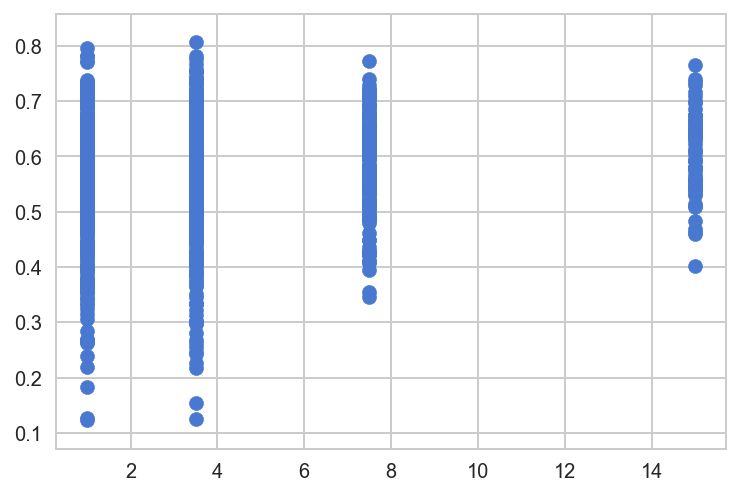

In [21]:
# TEMPORARY TROUBLESHOOTING

#print(resultsQ2SLS_both.result1A.summary())
plt.scatter(student_both.studytime_continuous, resultsQ2SLS_both.result2.fittedvalues);
#sns.violinplot(student_both.reason, student_both.traveltime)

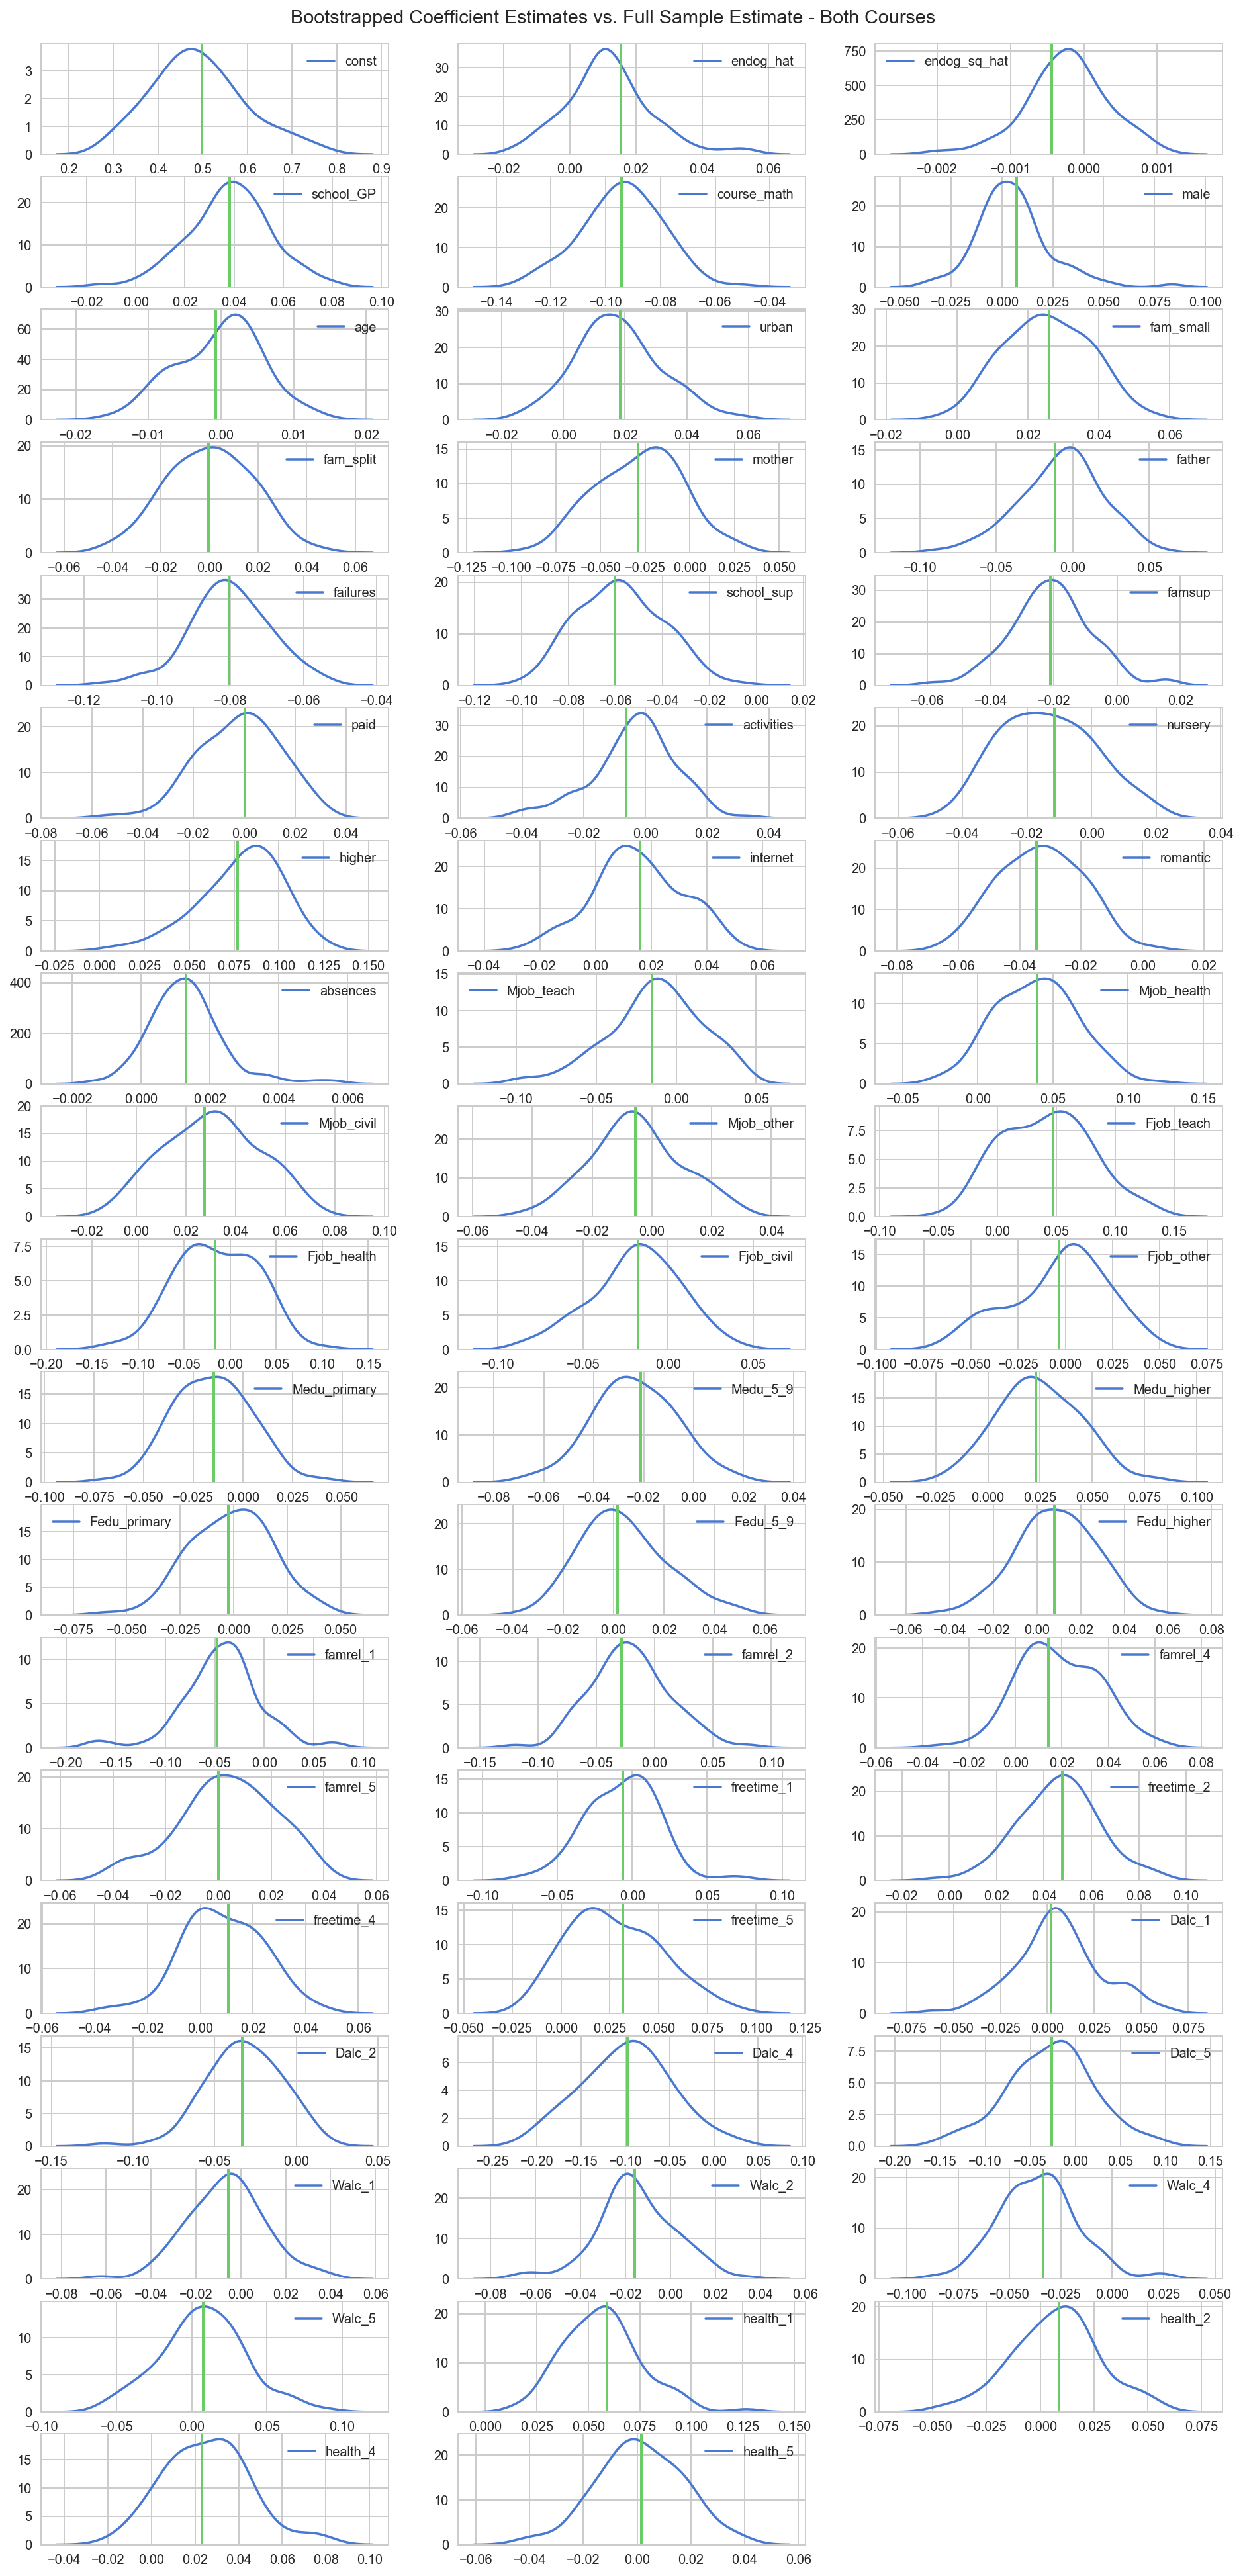

In [13]:
# Creating the plots - Both Courses
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs. Full Sample Estimate - Both Courses')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_both.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_both.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_both.result2.params[column_index], resultsQ2SLS_both.result2.params[column_index]], 
             [0, 1000], 
             linewidth=2)
plt.savefig('figures/btsrp_coeffs_both.png', bbox_inches='tight');    

In [14]:
# Results - Portuguese Language Course
coeff_estms_Q2SLS_por = pd.DataFrame([resultsQ2SLS_por.result2.params, resultsQ2SLS_por.beta_hat_boots.mean(axis=0), 
                                      resultsQ2SLS_por.beta_hat_boots_SE, resultsQ2SLS_por.beta_hat_boots_t, 
                                      resultsQ2SLS_por.beta_hat_boots_p]).transpose()
coeff_estms_Q2SLS_por.columns = ['Full_Sample', 'Btrsp Avg', 'Btrsp SE', 'Btrsp t-val', 'Btrsp p-val']
coeff_estms_Q2SLS_por.round(4)

,Full_Sample,Btrsp Avg,Btrsp SE,Btrsp t-val,Btrsp p-val
const,0.3790,0.3660,0.1036,3.6574,0.0003
endog_hat,0.0128,0.0042,0.0132,0.9698,0.3325
endog_sq_hat,-0.0007,-0.0000,0.0007,-1.0300,0.3034
school_GP,0.0652,0.0658,0.0189,3.4591,0.0006
male,-0.0322,-0.0355,0.0158,-2.0287,0.0429
age,0.0071,0.0088,0.0052,1.3732,0.1702
urban,0.0157,0.0148,0.0152,1.0301,0.3034
fam_small,0.0188,0.0205,0.0136,1.3823,0.1674
fam_split,-0.0109,-0.0100,0.0197,-0.5559,0.5785
mother,-0.0369,-0.0343,0.0276,-1.3372,0.1817


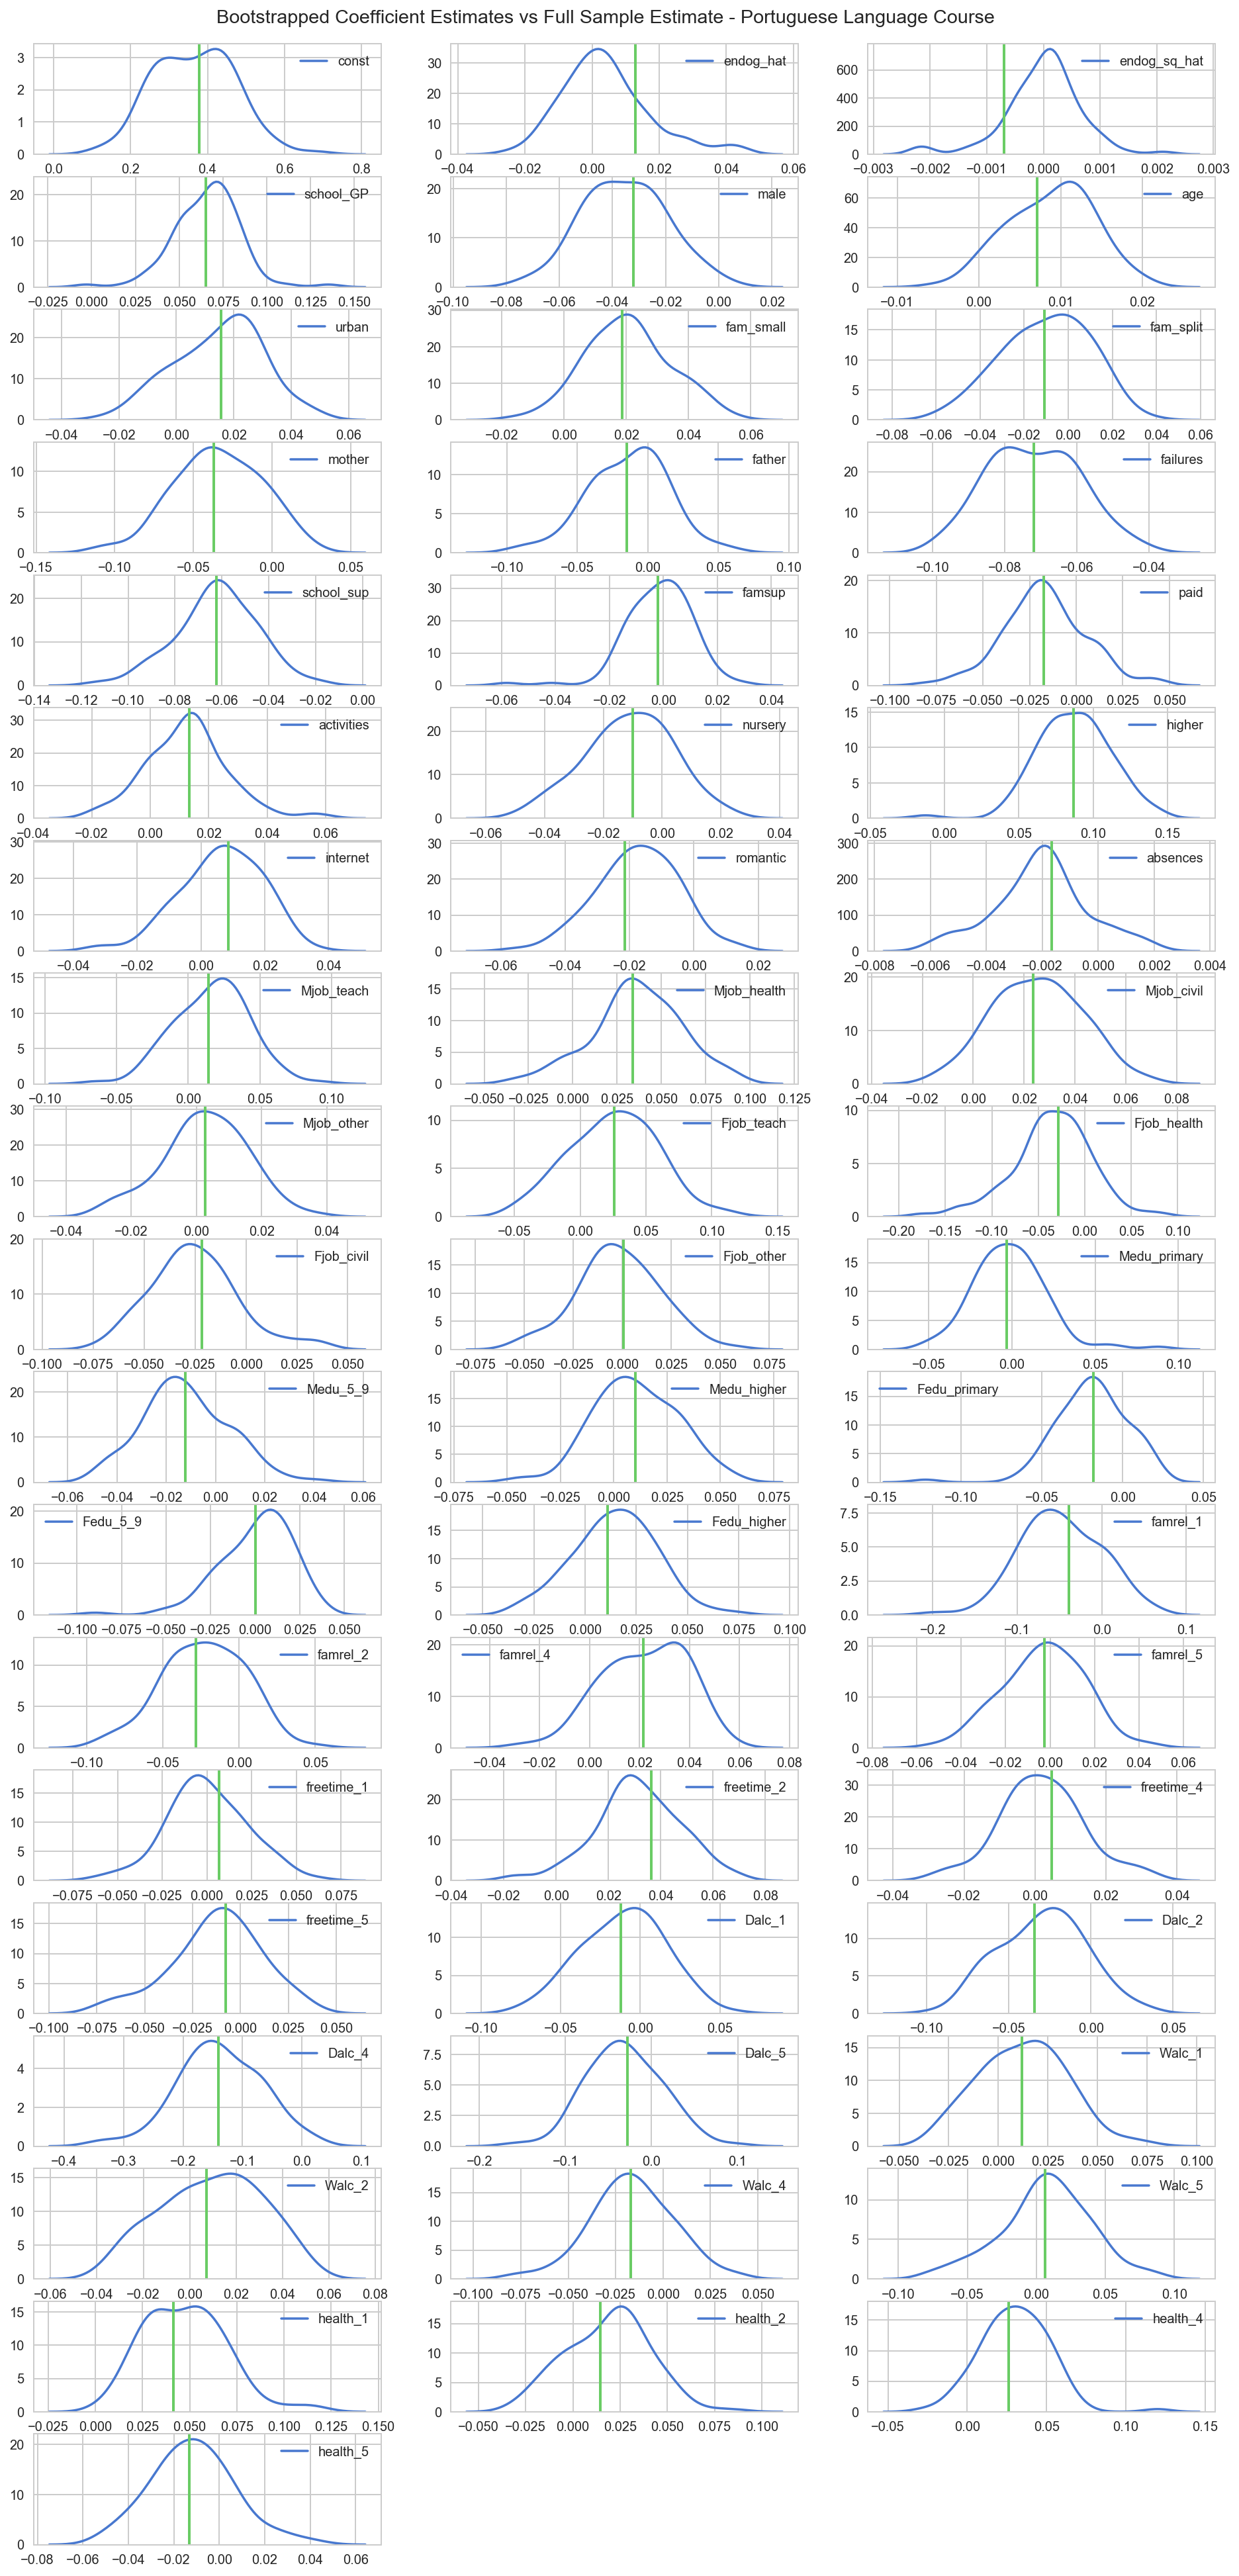

In [15]:
# Creating the plots - Portuguese Language Course
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs Full Sample Estimate - Portuguese Language Course')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_por.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_por.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_por.result2.params[column_index], resultsQ2SLS_por.result2.params[column_index]], 
             [0, 1000], 
             linewidth=2)
plt.savefig('figures/btsrp_coeffs_por.png', bbox_inches='tight');     

In [16]:
# Results - Mathematics Course
coeff_estms_Q2SLS_mat = pd.DataFrame([resultsQ2SLS_mat.result2.params, resultsQ2SLS_mat.beta_hat_boots.mean(axis=0), 
                                      resultsQ2SLS_mat.beta_hat_boots_SE, resultsQ2SLS_mat.beta_hat_boots_t, 
                                      resultsQ2SLS_mat.beta_hat_boots_p]).transpose()
coeff_estms_Q2SLS_mat.columns = ['Full_Sample', 'Btrsp Avg', 'Btrsp SE', 'Btrsp t-val', 'Btrsp p-val']
coeff_estms_Q2SLS_mat.round(4)

,Full_Sample,Btrsp Avg,Btrsp SE,Btrsp t-val,Btrsp p-val
const,0.8994,0.9365,0.2660,3.3811,0.0008
endog_hat,0.0115,0.0143,0.0192,0.5998,0.5490
endog_sq_hat,0.0002,-0.0000,0.0008,0.3043,0.7611
school_GP,-0.0360,-0.0434,0.0414,-0.8687,0.3856
male,0.0699,0.0703,0.0416,1.6807,0.0937
age,-0.0230,-0.0250,0.0118,-1.9431,0.0528
urban,0.0262,0.0311,0.0365,0.7188,0.4728
fam_small,0.0409,0.0408,0.0246,1.6610,0.0976
fam_split,0.0086,0.0173,0.0419,0.2064,0.8366
mother,-0.0475,-0.0587,0.0514,-0.9241,0.3561


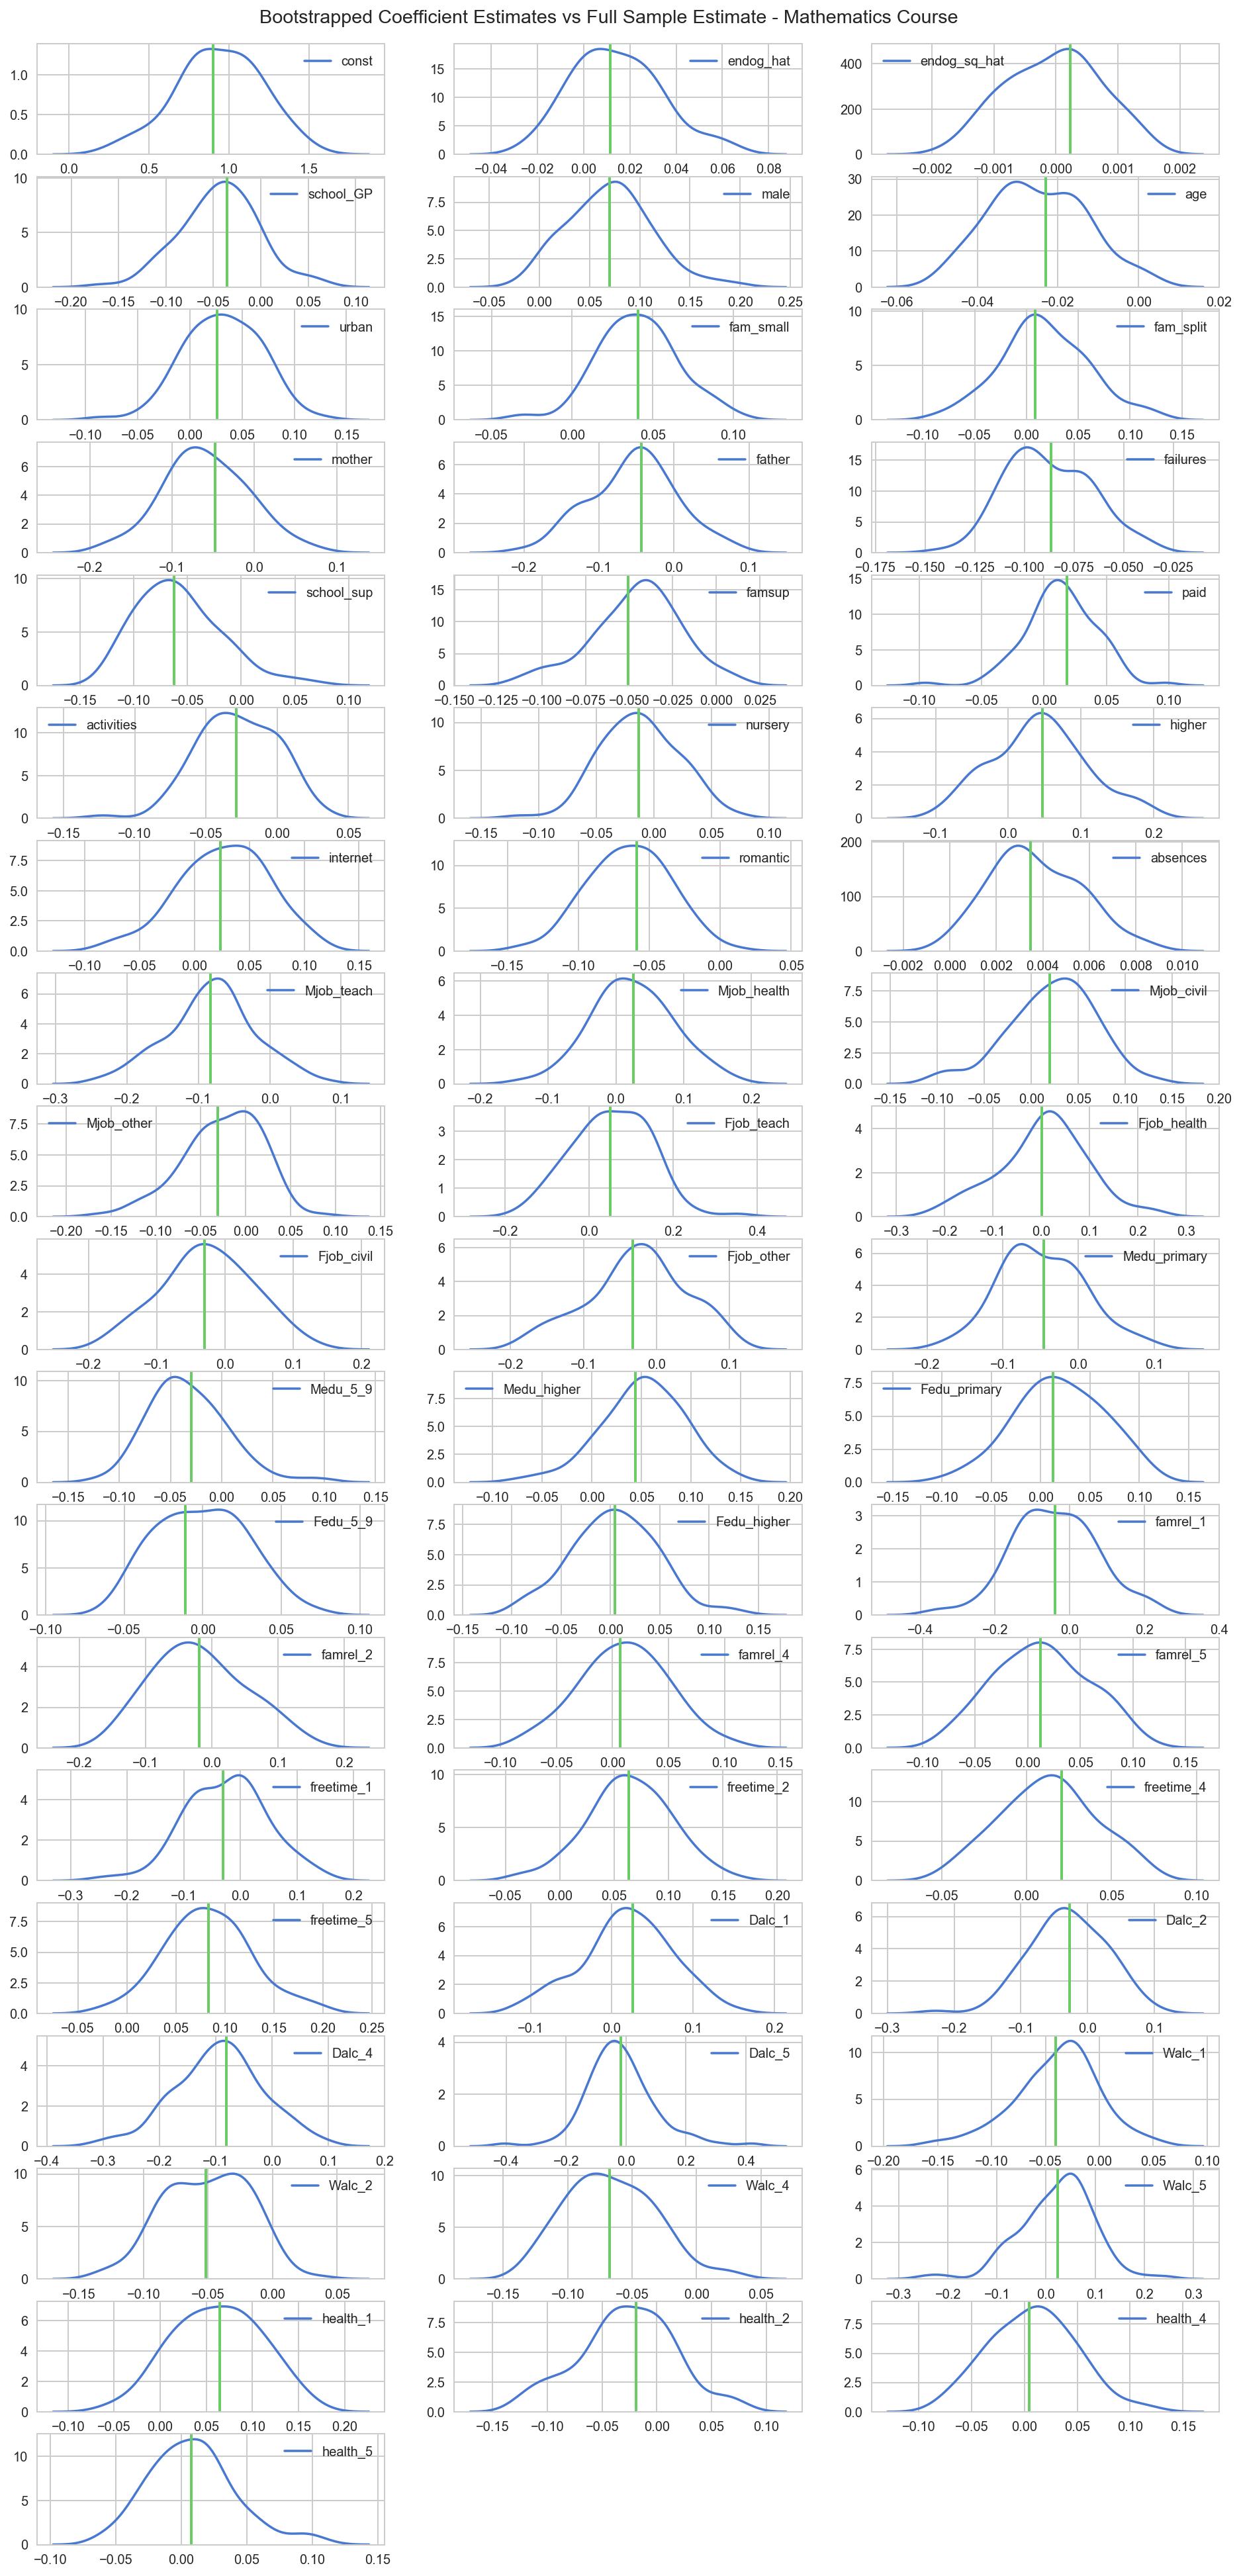

In [17]:
# Creating the plots - Mathematics Course
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs Full Sample Estimate - Mathematics Course')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_mat.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_mat.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_mat.result2.params[column_index], resultsQ2SLS_mat.result2.params[column_index]], 
             [0, 1000], 
             linewidth=2)
plt.savefig('figures/btsrp_coeffs_mat.png', bbox_inches='tight');     

In [18]:
#saving 2SLS model to our results directory
#import pickle
#with open('results/2SLS.pkl','wb') as f:
#    pickle.dump(results,f)